In [1]:
# ----------------------------------------------
# Yolo Keras Hand Detection
# ----------------------------------------------

from datetime import datetime
import numpy as np
import sys, getopt
import cv2
import os
from keras import backend as K
import time

os.environ['KERAS_BACKEND'] = 'tensorflow'

from keras.models import load_model
from keras.preprocessing import image

from matplotlib import pyplot as plt

#YOLOV2
#reference from https://github.com/experiencor/keras-yolo2
# https://github.com/experiencor/keras-yolo2/blob/master/LICENSE


Using TensorFlow backend.


In [16]:
def interpret_output_yolov2(output, img_width, img_height):
	anchors=[0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

	netout=output
	nb_class=1
	obj_threshold=0.4
	nms_threshold=0.3

	grid_h, grid_w, nb_box = netout.shape[:3]

	size = 4 + nb_class + 1;
	nb_box=5

	netout=netout.reshape(grid_h,grid_w,nb_box,size)

	boxes = []
	
	# decode the output by the network
	netout[..., 4]  = _sigmoid(netout[..., 4])
	netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
	netout[..., 5:] *= netout[..., 5:] > obj_threshold

	for row in range(grid_h):
		for col in range(grid_w):
			for b in range(nb_box):
				# from 4th element onwards are confidence and class classes
				classes = netout[row,col,b,5:]
				
				if np.sum(classes) > 0:
					# first 4 elements are x, y, w, and h
					x, y, w, h = netout[row,col,b,:4]

					x = (col + _sigmoid(x)) / grid_w # center position, unit: image width
					y = (row + _sigmoid(y)) / grid_h # center position, unit: image height
					w = anchors[2 * b + 0] * np.exp(w) / grid_w # unit: image width
					h = anchors[2 * b + 1] * np.exp(h) / grid_h # unit: image height
					confidence = netout[row,col,b,4]
					
					box = bounding_box(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
					
					boxes.append(box)

	# suppress non-maximal boxes
	for c in range(nb_class):
		sorted_indices = list(reversed(np.argsort([box.classes[c] for box in boxes])))

		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			
			if boxes[index_i].classes[c] == 0: 
				continue
			else:
				for j in range(i+1, len(sorted_indices)):
					index_j = sorted_indices[j]
					
					if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
						boxes[index_j].classes[c] = 0
						
	# remove the boxes which are less likely than a obj_threshold
	boxes = [box for box in boxes if box.get_score() > obj_threshold]
	
	result = []
	for i in range(len(boxes)):
		if(boxes[i].classes[0]==0):
			continue
		predicted_class = "hand"
		score = boxes[i].score
		result.append([predicted_class,(boxes[i].xmax+boxes[i].xmin)*img_width/2,(boxes[i].ymax+boxes[i].ymin)*img_height/2,(boxes[i].xmax-boxes[i].xmin)*img_width,(boxes[i].ymax-boxes[i].ymin)*img_height,score])

	return result

class bounding_box:
	def __init__(self, xmin, ymin, xmax, ymax, c = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		
		self.c     = c
		self.classes = classes

		self.label = -1
		self.score = -1

	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
		
		return self.label
	
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
			
		return self.score

def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  
	
	intersect = intersect_w * intersect_h

	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	
	union = w1*h1 + w2*h2 - intersect
	
	return float(intersect) / union

def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b

	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3          

def _sigmoid(x):
	return 1. / (1. + np.exp(-x))

def _softmax(x, axis=-1, t=-100.):
	x = x - np.max(x)
	
	if np.min(x) < t:
		x = x/np.min(x)*t
		
	e_x = np.exp(x)
	
	return e_x / e_x.sum(axis, keepdims=True)

#crop
def crop(x,y,w,h,margin,img_width,img_height):
	xmin = int(x-w*margin)
	xmax = int(x+w*margin)
	ymin = int(y-h*margin)
	ymax = int(y+h*margin)
	if xmin<0:
		xmin = 0
	if ymin<0:
		ymin = 0
	if xmax>img_width:
		xmax = img_width
	if ymax>img_height:
		ymax = img_height
	return xmin,xmax,ymin,ymax

#display result
def show_results(img,results, img_width, img_height):
	img_cp = img.copy()
	print('len results:',len(results))
	img_cp1 = cv2.cvtColor(img_cp, cv2.COLOR_BGR2RGB)
	for i in range(len(results)):
		x = int(results[i][1])
		y = int(results[i][2])
		w = int(results[i][3])//2
		h = int(results[i][4])//2

		xmin,xmax,ymin,ymax=crop(x,y,w,h,1.0,img_width,img_height)

		cv2.rectangle(img_cp1,(xmin,ymin),(xmax,ymax),(0,255,0), 30)
		cv2.rectangle(img_cp1,(xmin,ymin-20),(xmax,ymin),(125,125,125),-1)
		cv2.putText(img_cp1,results[i][0] + ' : %.2f' % results[i][5],(xmin+5,ymin-7),cv2.FONT_HERSHEY_SIMPLEX,2,(255,0, 0), 8 , cv2.LINE_AA)
	return img_cp1 #cv2.imshow('YoloKerasHandDetection',img_cp)


In [3]:
MODEL_ROOT_PATH="./pretrain/"

#Load Model
model_hand = load_model(MODEL_ROOT_PATH+'yolov2_tiny-hand.h5')

/root/team3/yes/envs/YoloKeras/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


1591505763.8125274
prediction time: 0.5008907318115234
len results: 2


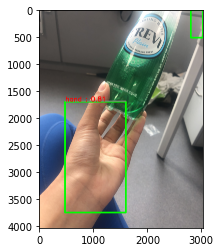

In [9]:

img=cv2.imread('./hand/5.jpg', cv2.IMREAD_COLOR)
img = img[...,::-1]  #BGR 2 RGB
inputs = img.copy() / 255.0

img_cv = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img_camera = cv2.resize(inputs, (416,416))
img_camera = np.expand_dims(img_camera, axis=0)
start = time.time()
print(start)
out2 = model_hand.predict(img_camera)[0]
end = time.time()
print('prediction time:',end-start)
results = interpret_output_yolov2(out2, img.shape[1], img.shape[0])

#Age and Gender Detection
img_cp=show_results(img_cv,results, img.shape[1], img.shape[0])
plt.imshow(img_cp)
plt.imsave('save.png',img_cp)


In [4]:
from os import listdir
from os.path import isfile, join

target_dir = './hand'
files = [f for f in listdir(target_dir) if isfile(join(target_dir, f))]
print(files)

['8.jpg', '3.jpg', '5.jpg', '2.jpg', '1.jpg', 'wild_hand.jpg', '9.jpg', '4.jpg', '6.jpg', '7.jpg', 'wallet.jpg', 'wallet2.jpg']


In [5]:
def get_result(img_path,img_name, dst_dir):

  file_name = os.path.join(dst_dir,img_name[:-4]+'_result.png')
  img=cv2.imread(img_path, cv2.IMREAD_COLOR)
  img = img[...,::-1]  #BGR 2 RGB
  inputs = img.copy() / 255.0
  
  img_cv = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img_camera = cv2.resize(inputs, (416,416))
  img_camera = np.expand_dims(img_camera, axis=0)
  start = time.time()
  out2 = model_hand.predict(img_camera)[0]
  end = time.time()
  print('prediction time:',end-start)
  start = time.time()
  results = interpret_output_yolov2(out2, img.shape[1], img.shape[0])
  end = time.time()
  print('interpret time:',end-start)

  #Age and Gender Detection
  img_cp=show_results(img_cv,results, img.shape[1], img.shape[0])
  plt.imshow(img_cp)
  print(file_name)
  plt.imsave(file_name,img_cp)

prediction time: 0.4474635124206543
interpret time: 0.007082462310791016
len results: 2
./result/5_result.png


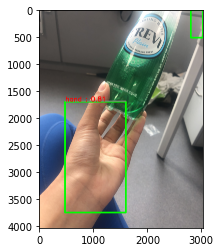

In [6]:
get_result('./hand/5.jpg','5.jpg','./result')

['B1_PS_H_test_000089.jpg', 'B1_PS_H_test_000004.jpg', 'B1_PS_H_test_000087.jpg', 'B1_PS_H_test_000064.jpg', 'B1_PS_H_test_000050.jpg', 'B1_PS_H_test_000020.jpg', 'B1_PS_H_test_000094.jpg', 'B1_PS_H_test_000015.jpg', 'B1_PS_H_test_000012.jpg', 'B1_PS_H_test_000069.jpg', 'B1_PS_H_test_000053.jpg', 'B1_PS_H_test_000040.jpg', 'B1_PS_H_test_000013.jpg', 'B1_PS_H_test_000083.jpg', 'B1_PS_H_test_000084.jpg', 'B1_PS_H_test_000085.jpg', 'B1_PS_H_test_000045.jpg', 'B1_PS_H_test_000018.jpg', 'B1_PS_H_test_000076.jpg', 'B1_PS_H_test_000049.jpg', 'B1_PS_H_test_000081.jpg', 'B1_PS_H_test_000057.jpg', 'B1_PS_H_test_000034.jpg', 'B1_PS_H_test_000088.jpg', 'B1_PS_H_test_000046.jpg', 'B1_PS_H_test_000043.jpg', 'B1_PS_H_test_000019.jpg', 'B1_PS_H_test_000029.jpg', 'B1_PS_H_test_000021.jpg', 'B1_PS_H_test_000070.jpg', 'B1_PS_H_test_000060.jpg', 'B1_PS_H_test_000065.jpg', 'B1_PS_H_test_000024.jpg', 'B1_PS_H_test_000059.jpg', 'B1_PS_H_test_000062.jpg', 'B1_PS_H_test_000009.jpg', 'B1_PS_H_test_000032.jpg', 

prediction time: 0.09347677230834961
interpret time: 0.007002353668212891
len results: 3
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/B1_PS_H_test_000029_result.png
prediction time: 0.09294414520263672
interpret time: 0.007036685943603516
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/B1_PS_H_test_000021_result.png
prediction time: 0.0947115421295166
interpret time: 0.006630897521972656
len results: 2
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/B1_PS_H_test_000070_result.png
prediction time: 0.10608959197998047
interpret time: 0.006958484649658203
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/B1_PS_H_test_000060_result.png
prediction time: 0.08852791786193848
interpret time: 0.0070018768310546875
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild

prediction time: 0.0952155590057373
interpret time: 0.007021188735961914
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/B1_PS_H_test_000010_result.png
prediction time: 0.09727668762207031
interpret time: 0.0065310001373291016
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/B1_PS_H_test_000023_result.png
prediction time: 0.09368777275085449
interpret time: 0.0065038204193115234
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/B1_PS_H_test_000082_result.png
prediction time: 0.09053421020507812
interpret time: 0.007067203521728516
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/B1_PS_H_test_000035_result.png
prediction time: 0.0902853012084961
interpret time: 0.00646662712097168
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/

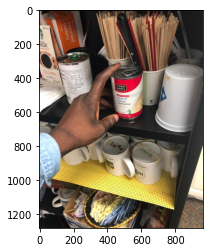

In [12]:
# img_path,img_name, dst_dir
PWD = os.getcwd()
target_dir = './TEgO/Testing/Images/in-the-wild/B1_PS_H_test/'
dst_dir_sangdae = 'TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/'

dst_dir = os.path.join(PWD ,dst_dir_sangdae)

if not os.path.isdir(dst_dir):
    os.makedirs(dst_dir)

files = [f for f in listdir(target_dir) if isfile(join(target_dir, f))]
print(files)

for i in files:
   file_name = os.path.join(target_dir,i)
   get_result(file_name, i,dst_dir )

/root/Edwin/hand-detection-YoloKeras
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/
['S1_PS_H_test_000050.jpg', 'S1_PS_H_test_000066.jpg', 'S1_PS_H_test_000068.jpg', 'S1_PS_H_test_000081.jpg', 'S1_PS_H_test_000039.jpg', 'S1_PS_H_test_000015.jpg', 'S1_PS_H_test_000089.jpg', 'S1_PS_H_test_000047.jpg', 'S1_PS_H_test_000018.jpg', 'S1_PS_H_test_000058.jpg', 'S1_PS_H_test_000044.jpg', 'S1_PS_H_test_000077.jpg', 'S1_PS_H_test_000071.jpg', 'S1_PS_H_test_000090.jpg', 'S1_PS_H_test_000026.jpg', 'S1_PS_H_test_000004.jpg', 'S1_PS_H_test_000048.jpg', 'S1_PS_H_test_000036.jpg', 'S1_PS_H_test_000094.jpg', 'S1_PS_H_test_000033.jpg', 'S1_PS_H_test_000010.jpg', 'S1_PS_H_test_000042.jpg', 'S1_PS_H_test_000009.jpg', 'S1_PS_H_test_000052.jpg', 'S1_PS_H_test_000063.jpg', 'S1_PS_H_test_000031.jpg', 'S1_PS_H_test_000054.jpg', 'S1_PS_H_test_000014.jpg', 'S1_PS_H_test_000085.jpg', 'S1_PS_H_test_000041.jpg', 'S1_PS_H_test_000062.jpg', 'S1_PS_H_test_000092.jpg', 'S1_P

prediction time: 0.10171723365783691
interpret time: 0.00692439079284668
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000054_result.png
prediction time: 0.10159182548522949
interpret time: 0.0067555904388427734
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000014_result.png
prediction time: 0.10356783866882324
interpret time: 0.0063512325286865234
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000085_result.png
prediction time: 0.10396361351013184
interpret time: 0.006714344024658203
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000041_result.png
prediction time: 0.10482931137084961
interpret time: 0.0064203739166259766
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Imag

prediction time: 0.10206818580627441
interpret time: 0.006887912750244141
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000091_result.png
prediction time: 0.10302186012268066
interpret time: 0.006397247314453125
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000080_result.png
prediction time: 0.10261225700378418
interpret time: 0.0068624019622802734
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000073_result.png
prediction time: 0.10391521453857422
interpret time: 0.006855010986328125
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000022_result.png
prediction time: 0.1025843620300293
interpret time: 0.006684064865112305
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images

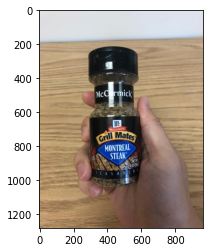

In [7]:
# img_path,img_name, dst_dir
PWD = os.getcwd()
print(PWD)
target_dir = 'TEgO/Testing/Images/in-the-vanilla/S1_PS_H_test/'
dst_dir_sangdae = 'TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/'

target_dir = os.path.join(PWD ,target_dir)
dst_dir = os.path.join(PWD ,dst_dir_sangdae)
print(dst_dir)
if not os.path.isdir(dst_dir):
    os.makedirs(dst_dir)

files = [f for f in listdir(target_dir) if isfile(join(target_dir, f))]
print(files)

for i in files:
   file_name = os.path.join(target_dir,i)
   get_result(file_name, i,dst_dir )

In [8]:
import os

def experiment(target_subdir,dst_dir):
    
    if not os.path.isdir(dst_dir):
        os.makedirs(dst_dir)

    files = [f for f in os.listdir(target_subdir) if os.path.isfile(os.path.join(target_subdir, f))]
    print(files)

    for i in files:
       file_name = os.path.join(target_subdir,i)
       get_result(file_name, i,dst_dir )


In [9]:
PWD = os.getcwd()
target_str = 'TEgO/Testing/Images/in-the-vanilla/'
dst_dir_str = 'TEgO_result/Testing/Images/in-the-vanilla/'
target_dir = os.path.join(PWD ,target_str)
dst_dir_str = os.path.join(PWD ,dst_dir_str)
a = os.listdir(target_dir)

In [10]:
print(a)

['.ipynb_checkpoints', 'S1_PS_H_test_NIL', 'S1_PS_H_test_torch', 'S1_PS_H_test']


In [11]:
print(target_dir)
print(dst_dir_str)
target_subdirs = [os.path.join(target_dir, direc) for direc in a]
dst_subdirs = [os.path.join(dst_dir_str, direc) for direc in a]


/root/Edwin/hand-detection-YoloKeras/TEgO/Testing/Images/in-the-vanilla/
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/


In [12]:
print(target_subdirs)

['/root/Edwin/hand-detection-YoloKeras/TEgO/Testing/Images/in-the-vanilla/B1_PS_NH_test', '/root/Edwin/hand-detection-YoloKeras/TEgO/Testing/Images/in-the-vanilla/S1_PS_H_test_NIL', '/root/Edwin/hand-detection-YoloKeras/TEgO/Testing/Images/in-the-vanilla/B1_PV_H_test_torch', '/root/Edwin/hand-detection-YoloKeras/TEgO/Testing/Images/in-the-vanilla/S1_PS_H_test_torch', '/root/Edwin/hand-detection-YoloKeras/TEgO/Testing/Images/in-the-vanilla/S1_PS_NH_test', '/root/Edwin/hand-detection-YoloKeras/TEgO/Testing/Images/in-the-vanilla/S1_PS_H_test', '/root/Edwin/hand-detection-YoloKeras/TEgO/Testing/Images/in-the-vanilla/B1_PV_NH_test_torch', '/root/Edwin/hand-detection-YoloKeras/TEgO/Testing/Images/in-the-vanilla/B1_PV_H_test', '/root/Edwin/hand-detection-YoloKeras/TEgO/Testing/Images/in-the-vanilla/B1_PV_H_test_NIL', '/root/Edwin/hand-detection-YoloKeras/TEgO/Testing/Images/in-the-vanilla/B1_PS_H_test_torch', '/root/Edwin/hand-detection-YoloKeras/TEgO/Testing/Images/in-the-vanilla/B1_PV_NH_te

In [12]:
print(dst_subdirs)

['/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/.ipynb_checkpoints', '/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_NIL', '/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch', '/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test']


[]
['S1_PS_H_test_NIL_000013.jpg', 'S1_PS_H_test_NIL_000081.jpg', 'S1_PS_H_test_NIL_000077.jpg', 'S1_PS_H_test_NIL_000058.jpg', 'S1_PS_H_test_NIL_000060.jpg', 'S1_PS_H_test_NIL_000017.jpg', 'S1_PS_H_test_NIL_000061.jpg', 'S1_PS_H_test_NIL_000084.jpg', 'S1_PS_H_test_NIL_000020.jpg', 'S1_PS_H_test_NIL_000057.jpg', 'S1_PS_H_test_NIL_000076.jpg', 'S1_PS_H_test_NIL_000054.jpg', 'S1_PS_H_test_NIL_000074.jpg', 'S1_PS_H_test_NIL_000079.jpg', 'S1_PS_H_test_NIL_000004.jpg', 'S1_PS_H_test_NIL_000003.jpg', 'S1_PS_H_test_NIL_000089.jpg', 'S1_PS_H_test_NIL_000067.jpg', 'S1_PS_H_test_NIL_000092.jpg', 'S1_PS_H_test_NIL_000015.jpg', 'S1_PS_H_test_NIL_000030.jpg', 'S1_PS_H_test_NIL_000073.jpg', 'S1_PS_H_test_NIL_000053.jpg', 'S1_PS_H_test_NIL_000006.jpg', 'S1_PS_H_test_NIL_000044.jpg', 'S1_PS_H_test_NIL_000029.jpg', 'S1_PS_H_test_NIL_000001.jpg', 'S1_PS_H_test_NIL_000014.jpg', 'S1_PS_H_test_NIL_000094.jpg', 'S1_PS_H_test_NIL_000064.jpg', 'S1_PS_H_test_NIL_000028.jpg', 'S1_PS_H_test_NIL_000043.jpg', 'S1_

prediction time: 0.10358166694641113
interpret time: 0.006432294845581055
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_NIL/S1_PS_H_test_NIL_000044_result.png
prediction time: 0.10273528099060059
interpret time: 0.006819725036621094
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_NIL/S1_PS_H_test_NIL_000029_result.png
prediction time: 0.10470199584960938
interpret time: 0.006430625915527344
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_NIL/S1_PS_H_test_NIL_000001_result.png
prediction time: 0.11404752731323242
interpret time: 0.006661891937255859
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_NIL/S1_PS_H_test_NIL_000014_result.png
prediction time: 0.1085965633392334
interpret time: 0.006863832473754883
len results: 0
/root/Edwin/hand-detection-YoloK

prediction time: 0.10729312896728516
interpret time: 0.006764411926269531
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_NIL/S1_PS_H_test_NIL_000052_result.png
prediction time: 0.10323023796081543
interpret time: 0.006851911544799805
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_NIL/S1_PS_H_test_NIL_000022_result.png
prediction time: 0.10486602783203125
interpret time: 0.006930351257324219
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_NIL/S1_PS_H_test_NIL_000091_result.png
prediction time: 0.1014561653137207
interpret time: 0.0063076019287109375
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_NIL/S1_PS_H_test_NIL_000055_result.png
prediction time: 0.10315251350402832
interpret time: 0.0068552494049072266
len results: 0
/root/Edwin/hand-detection-Yol

prediction time: 0.10259699821472168
interpret time: 0.006827354431152344
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch/S1_PS_H_test_torch_000063_result.png
prediction time: 0.10168218612670898
interpret time: 0.00629734992980957
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch/S1_PS_H_test_torch_000080_result.png
prediction time: 0.10307765007019043
interpret time: 0.006668567657470703
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch/S1_PS_H_test_torch_000018_result.png
prediction time: 0.10300278663635254
interpret time: 0.006764411926269531
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch/S1_PS_H_test_torch_000062_result.png
prediction time: 0.10525703430175781
interpret time: 0.006758451461791992
len results: 0
/root/Edwin/hand

prediction time: 0.10093092918395996
interpret time: 0.0070362091064453125
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch/S1_PS_H_test_torch_000082_result.png
prediction time: 0.10360527038574219
interpret time: 0.006734132766723633
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch/S1_PS_H_test_torch_000090_result.png
prediction time: 0.10193181037902832
interpret time: 0.006392478942871094
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch/S1_PS_H_test_torch_000031_result.png
prediction time: 0.10566568374633789
interpret time: 0.006836891174316406
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch/S1_PS_H_test_torch_000092_result.png
prediction time: 0.10746097564697266
interpret time: 0.006319522857666016
len results: 0
/root/Edwin/ha

prediction time: 0.10164356231689453
interpret time: 0.0068514347076416016
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch/S1_PS_H_test_torch_000074_result.png
prediction time: 0.10055851936340332
interpret time: 0.0065152645111083984
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch/S1_PS_H_test_torch_000002_result.png
prediction time: 0.09951949119567871
interpret time: 0.0067691802978515625
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch/S1_PS_H_test_torch_000047_result.png
prediction time: 0.10097265243530273
interpret time: 0.006898641586303711
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch/S1_PS_H_test_torch_000043_result.png
prediction time: 0.10140323638916016
interpret time: 0.0068094730377197266
len results: 0
/root/Edwin

prediction time: 0.10113072395324707
interpret time: 0.006953716278076172
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000089_result.png
prediction time: 0.10197830200195312
interpret time: 0.00648951530456543
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000047_result.png
prediction time: 0.1032860279083252
interpret time: 0.0068209171295166016
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000018_result.png
prediction time: 0.10393047332763672
interpret time: 0.006812572479248047
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000058_result.png
prediction time: 0.10348343849182129
interpret time: 0.006900310516357422
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/

prediction time: 0.10085844993591309
interpret time: 0.0068242549896240234
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000019_result.png
prediction time: 0.10203242301940918
interpret time: 0.00638270378112793
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000070_result.png
prediction time: 0.10137200355529785
interpret time: 0.006947517395019531
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000001_result.png
prediction time: 0.10138511657714844
interpret time: 0.006390810012817383
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000065_result.png
prediction time: 0.11352777481079102
interpret time: 0.006742000579833984
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images

prediction time: 0.10155725479125977
interpret time: 0.006774187088012695
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000055_result.png
prediction time: 0.0990762710571289
interpret time: 0.006737232208251953
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000037_result.png
prediction time: 0.10174179077148438
interpret time: 0.0068111419677734375
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000088_result.png
prediction time: 0.10230779647827148
interpret time: 0.006376981735229492
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000000_result.png
prediction time: 0.1031806468963623
interpret time: 0.006851673126220703
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/

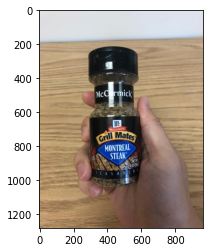

In [17]:
for i in range(len(target_subdirs)):
    experiment(target_subdirs[i],dst_subdirs[i])